In [45]:
## -- 필요한 모듈 및 패키지 로드

from pyspark.sql.types import * 
import pyspark.sql.functions as F

import warnings 
warnings.filterwarnings('ignore') # warning 메시지 반환되지 않도록 설정

import matplotlib.pyplot as plt # 시각화를 위한 모듈

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" # 한 셀(cell)에서의 코드 실행 결과가 다 보이도록 설정

In [85]:
# Bucket 관련 사전 설정

OUTPUT_BUCKET_FOLDER = "gs://cap-18/output/"
DATA_BUCKET_FOLDER = "gs://cap-18/data/"

# Part 1: Analyzing page_views.csv

cf) (Py)Spark에서는 아래와 같이 `StructType`을 사용하여 출력 데이터 프레임의 구조를 생성(column명, 변수의 형(type) 표시)한다.

In [46]:
## -- page_views 데이터 로드

# page_views 파일 저장을 위한 구조(schema) 설정
page_views_schema = StructType(
                    [StructField("uuid", StringType(), True), # uuid 컬럼은 StringType으로, Nullable은 True로 설정
                    StructField("document_id", IntegerType(), True),
                    StructField("timestamp", IntegerType(), True),
                    StructField("platform", IntegerType(), True),
                    StructField("geo_location", StringType(), True),
                    StructField("traffic_source", IntegerType(), True)]
                    )

# Google Storage에 저장된 page_views 파일 로드
page_views_df = spark.read.schema(page_views_schema).options(header='true', inferschema='false', nullValue='\\N') \
                .csv("gs://cap-18/data/page_views.csv")

Spark에서는 처리해야 하는 파일 크기를 고려하여 파티션의 수를 설정한다. `page_views` 파일은 파티션의 수가 708개로, 각각이 약 125MB를 처리하도록 설정(88GB / 708개)된 것을 확인할 수 있다. 작업 명령을 내리면, Spark 작업자 노드 가운데 실행 가능한 노드에서 작업이 병렬적으로 진행된다(processed in parallel).

In [47]:
page_views_df.rdd.getNumPartitions()

708

## 0. 페이지 뷰의 구조 

#### 1) 테이블 구조 확인

`page_views`에는 `uuid`, `document_id`, `timestamp`, `platform`, `geo_location`, `traffic_source`가 포함되어 있다.

In [4]:
# page_views_df의 첫 20행 확인
%time page_views_df.show()

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
|2aa611f32875c7|        120| 71495491|       1|       CA>ON|             2|
|f55a6eaf2b34ab|        120| 73309199|       1|       BR>27|             2|
|cc01b582c8cbff|        120| 50033577|       1|       CA>BC|             2|
|6c802978b8dd4d|        120| 66590306|       1|       CA>ON|             2|
|f4e423314303ff|        120| 48314254|       1|   US>LA>622|             1|
|3937372ca27

#### 2) 변수별 탐색

변수별로 데이터를 살펴보자.

In [48]:
# 변수별 결측치 탐색

from pyspark.sql.functions import isnan, when, count, col # 계산을 위한 모듈 로드
page_views_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in page_views_df.columns]).show() # 변수별 결측치 수 계산

+----+-----------+---------+--------+------------+--------------+
|uuid|document_id|timestamp|platform|geo_location|traffic_source|
+----+-----------+---------+--------+------------+--------------+
|   0|          0|        0|       0|           0|             0|
+----+-----------+---------+--------+------------+--------------+



`page_views_sample`, `events` 테이블에서 `geo_location`의 결측치가 각각 **145건, 340건** 포함된 것으로 나타났다. 어떻게 된 일일까?


이를 알아보고자 `geo_location`에서 고유한 값의 개수를 세고, 값의 형태를 살펴보았다.

In [29]:
# geo_location 컬럼에서 고유한 값의 개수 확인
page_views_df.select('geo_location').distinct().count()

3477

In [31]:
page_views_df.select('geo_location').distinct().show(3477)

+------------+
|geo_location|
+------------+
|       BG>50|
|       IE>16|
|       MA>57|
|       CO>02|
|       US>NY|
|       IL>01|
|   US>MT>756|
|   US>MS>673|
|       NL>10|
|          DZ|
|       ES>07|
|          LT|
|       TH>46|
|       AE>05|
|       ZM>03|
|          MM|
|       CM>09|
|   US>MT>764|
|       EC>03|
|       DZ>42|
|   US>FL>548|
|       SE>26|
|       EC>18|
|       IN>20|
|       BR>08|
|       BZ>01|
|       HU>18|
|       AS>00|
|       HU>09|
|   US>MT>881|
|       CN>01|
|       KZ>12|
|       MK>84|
|       RU>01|
|   US>ID>757|
|       GB>P2|
|   US>SC>570|
|       GB>M1|
|       JP>13|
|       PF>00|
|       SI>F3|
|       NI>15|
|       BF>53|
|   US>PA>554|
|       BY>05|
|       PH>B8|
|       DZ>34|
|       AZ>00|
|   US>VA>569|
|       PG>16|
|       JP>11|
|       PL>82|
|       DO>15|
|       RU>73|
|          TC|
|       RU>20|
|          CI|
|       PH>C8|
|   US>OK>623|
|       PH>D4|
|       NG>23|
|       SI>J4|
|       VN>24|
|       SI

육안으로 확인한 결과 결측치는 없어보인다. 정확하게 확인하고자 `events` 테이블에서 `geo_location`이 결측치였던 한 사용자의 페이지 뷰를 확인해보자.

In [34]:
# events
page_views_df.filter(F.col('uuid') == 'f8a603cb663c2c').show()

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|f8a603cb663c2c|    1765569|  8280265|       2|          NA|             1|
|f8a603cb663c2c|    1740188|  4928600|       2|          NA|             1|
|f8a603cb663c2c|     877318|  5088918|       2|          NA|             1|
|f8a603cb663c2c|    1767876|  4680826|       2|          NA|             1|
|f8a603cb663c2c|    1128355|  5203379|       2|          NA|             1|
|f8a603cb663c2c|    1388374|  5413508|       2|          NA|             1|
|f8a603cb663c2c|    1742973|  4778087|       2|          NA|             1|
+--------------+-----------+---------+--------+------------+--------------+



결측치가 아닌 문자열(NA)로 인식했음을 알 수 있다. 

In [35]:
page_views_df.filter(F.col('geo_location') == 'NA').count()

31908

다행히 다른 변수에서는 이런 문제가 없어보인다.

In [36]:
# traffic_source 컬럼의 결측치 개수: 
page_views_df.filter(F.col('traffic_source') == 'NA').count() 

0

In [82]:
# document_id 컬럼의 결측치 개수:
page_views_df.filter(F.col('document_id') == 'NA').count()

0

In [83]:
# document_id 컬럼의 고유값 개수:
page_views_df.select('document_id').distinct().count()

2835560

In [38]:
# platform 컬럼의 결측치 개수:
page_views_df.filter(F.col('platform') == 'NA').count()

0

`geo_location`의 NA는 최빈값인 US로 대체하자.

In [51]:
from pyspark.sql.functions import *
page_views_df = page_views_df.withColumn('geo_location', regexp_replace('geo_location', 'NA', 'US'))
page_views_df.show(1)
page_views_df.filter(F.col('geo_location') == 'NA').count()

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
+--------------+-----------+---------+--------+------------+--------------+
only showing top 1 row



0

`geo_location`이 NA인 행이 전부 삭제되었다.

`geo_location`의 첫 두 문자열을 추출하여 국가 정보를 표시하는 `country` 열을 만들어보자.

In [52]:
page_views_df = page_views_df.withColumn('country', page_views_df.geo_location.substr(1, 2))
page_views_df.show(3)

+--------------+-----------+---------+--------+------------+--------------+-------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|country|
+--------------+-----------+---------+--------+------------+--------------+-------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|     RS|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|     VN|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|     KR|
+--------------+-----------+---------+--------+------------+--------------+-------+
only showing top 3 rows



## 1. 페이지 뷰의 timetsamp

먼저 `timestamp` 변수를 요약 통계량 중심으로 살펴보자.

#### 1) page_views의 timestamp의 요약통계량(빈도, 최대값, 평균, 최소값, 표준편차)

In [55]:
page_views_timestamp_stats_df = page_views_df.describe('timestamp')

In [56]:
page_views_timestamp_stats = page_views_timestamp_stats_df.rdd.collectAsMap()
page_views_timestamp_stats # timestamp의 요약 통계량(count, max, mean, min, stddev) 출력

{u'count': u'2034275448',
 u'max': u'1296000000',
 u'mean': u'6.514646047360122E8',
 u'min': u'0',
 u'stddev': u'3.809745454636916E8'}

#### 2) page_views의 timestamp 분포

`timestamp`의 분포를 통해 다음의 세 가지 사실을 확인할 수 있다.

- `page_views`에 포함된 데이터는 2016년 6월 14일부터 2016년 6월 28일까지 약 2주 간 수집된 로그 데이터


- timestamp의 최소값/최대값이 대략 새벽 4시로 나타난 것을 보아, UTC-4를 사용하여 데이터셋이 filter되었음을 추정 가능


- 사용자의 선호를 보다 정교하게 모델링하기 위해서는(i.e. `page_views` 데이터가 의미있게 쓰이기 위해서는) 본 데이터가 이 기간 동안 수집된 사용자들의 전체 페이지 방문 기록(full log)이어야 함.

In [53]:
# 시간 데이터 처리를 위한 모듈 로드
from datetime import datetime

# UTC 시간을 변환하기 위한 함수 설정
def convert_odd_timestamp(timestamp_ms_relative):
    TIMESTAMP_DELTA=1465876799998
    return datetime.fromtimestamp((int(timestamp_ms_relative)+TIMESTAMP_DELTA)//1000)

In [57]:
## -- 시간 변환 함수의 작동 원리 파악

# 예 1) min(i.e. 0이 timestamp로 주어졌을 때)을 변환한 결과
print(convert_odd_timestamp(page_views_timestamp_stats['min']))

# 예 2) max(i.e. 1296000000이 timestamp로 주어졌을 때)을 변환한 결과
print(convert_odd_timestamp(page_views_timestamp_stats['max']))

2016-06-14 03:59:59
2016-06-29 03:59:59


## 2. 유저별 페이지 뷰

In [58]:
import pandas as pd

In [59]:
# 사용자(uuid)별 페이지뷰의 빈도 계산 
page_views_by_user_df = page_views_df.groupBy('uuid').count()

In [60]:
# 사용자별 페이지뷰의 빈도를 그룹으로 묶기
page_views_user_distribution_df = page_views_by_user_df.select('count').groupby('count').count()

In [61]:
# PySpark에서의 데이터프레임을 Pandas 데이터프레임으로 변환
page_views_by_user_pandas = page_views_user_distribution_df.toPandas()

In [62]:
len(page_views_by_user_pandas)

563

#### 1) 고유한(distinct) 사용자들의 페이지뷰 수

유저당 페이지 방문 기록을 살펴보면, **458,234,809명**의 사용자(전체 사용자의 약 63.9%)는 단 한 번만 페이지 방문을 했고, 94,245,789명(전체 사용자의 약 13.1%)은 두 차례만 방문한 것을 알 수 있다.

In [63]:
page_views_by_user_pandas.columns = ['pageViewsByUser', 'usersCount']
page_views_by_user_pandas = page_views_by_user_pandas.set_index('pageViewsByUser').sort_index()
page_views_by_user_pandas.head(10)

,usersCount
pageViewsByUser,
1,458234809
2,94245789
3,44977389
4,26869230
5,17942534
6,12878964
7,9691732
8,7573614
9,6036047


`page_views`에는 사용자 **717,506,889명**의 페이지 방문 기록이 포함되어 있다.

In [64]:
distinct_users_count = page_views_by_user_pandas['usersCount'].sum()
distinct_users_count

717506889

In [65]:
%matplotlib inline

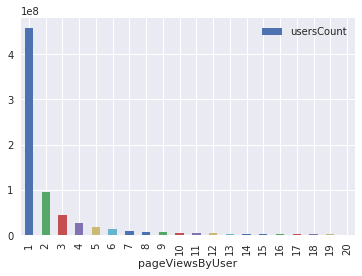

In [66]:
page_views_by_user_pandas.head(20).plot.bar(y = 'usersCount')

페이지 뷰 수를 유저별로 집계하여 누적 비율을 계산해보면 다음과 같다.

In [67]:
page_views_by_user_pandas['cum_perc'] = (page_views_by_user_pandas['usersCount'].cumsum() / distinct_users_count) * 100
page_views_by_user_pandas.head(10)

,usersCount,cum_perc
pageViewsByUser,,
1,458234809,63.864865
2,94245789,77.000041
3,44977389,83.268606
4,26869230,87.013411
5,17942534,89.514088
6,12878964,91.309049
7,9691732,92.659800
8,7573614,93.715346
9,6036047,94.556598


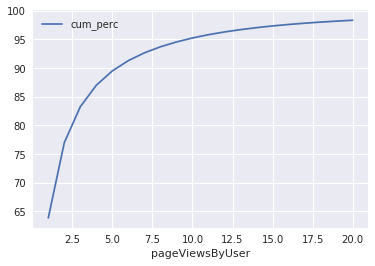

In [33]:
page_views_by_user_pandas.head(20).plot.line(y = 'cum_perc')

일부 사용자는 페이지 뷰 수가 많다.

In [36]:
page_views_by_user_pandas.tail(20)

,usersCount,cum_perc
pageViewsByUser,,
625,1,99.999997
632,1,99.999997
638,1,99.999997
640,1,99.999998
649,1,99.999998
651,1,99.999998
652,1,99.999998
655,1,99.999998
659,1,99.999998


`page_views`에서 유저당 페이지 뷰의 평균(2.835)은 `events` 데이터에서의 유저당 페이지 뷰의 평균(1.168)보다 높은 것을 알 수 있다.

In [25]:
avg_page_views_by_user = page_views_count / float(distinct_users_count)
avg_page_views_by_user

2.8351998833561027

## 3. 접속 기기(platform)별 페이지 뷰

In [34]:
page_views_by_platform_pandas = page_views_df.groupBy('platform').count().toPandas()

In [35]:
page_views_by_platform_pandas = page_views_by_platform_pandas.set_index('platform').sort_index()
page_views_by_platform_pandas

,count
platform,
1,790149483
2,1053365944
3,190760021


#### 1) 접속 기기별 페이지 뷰의 분포

접속 기기별 페이지 뷰의 분포를 살펴본 결과, 모바일 - 데스크탑 - 태블릿 순으로 높게 나타났다.

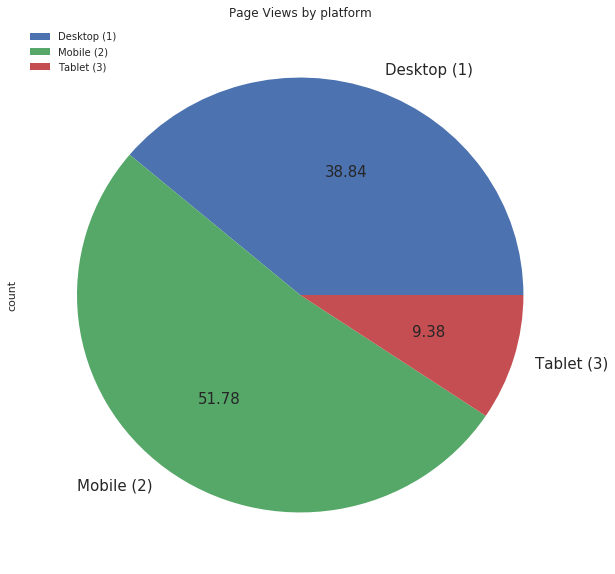

In [36]:
page_views_by_platform_pandas.plot.pie(y='count', figsize=(10, 10), labels=['Desktop (1)', 'Mobile (2)', 'Tablet (3)'], 
              title='Page Views by platform', autopct='%.2f', fontsize=15)

## 4. 접속 경로(Traffic Source)별 페이지 뷰

In [37]:
page_views_by_traffic_source_pandas = page_views_df.groupBy('traffic_source').count().toPandas()

In [38]:
page_views_by_traffic_source_pandas = page_views_by_traffic_source_pandas.set_index('traffic_source').sort_index()
page_views_by_traffic_source_pandas

,count
traffic_source,
1,1293550863
2,343133832
3,397590753


#### 1) 접속 경로별 페이지 뷰의 분포

접속 경로별 페이지 뷰를 살펴본 결과, 내부(internal) - 검색(search) - 소셜(social) 순으로 높게 나타났다.

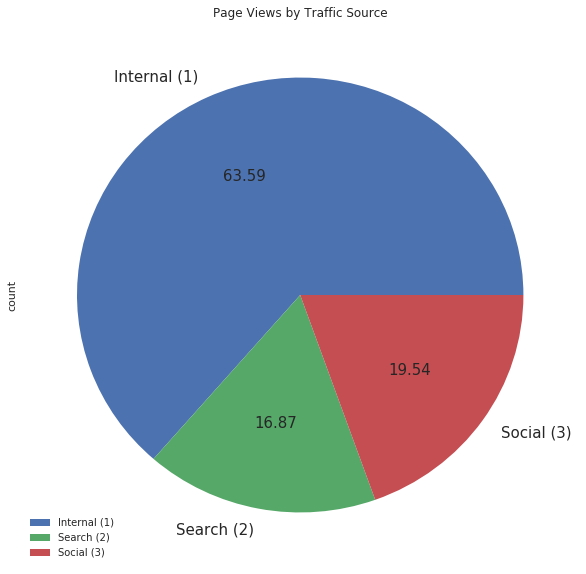

In [39]:
page_views_by_traffic_source_pandas.plot.pie(y='count', figsize=(10, 10), labels=['Internal (1)', 'Search (2)', 'Social (3)'], 
              title='Page Views by Traffic Source', autopct='%.2f', fontsize=15)

## 5. 특정 페이지에 재방문하는 사용자들

특정 페이지에 재방문(i.e. 두 번 이상 접속한 것을 지칭)한 기록은 **47,937,415 건**으로 높게 나타났다.

In [40]:
page_views_by_user_doc_df = page_views_df.groupBy(['uuid','document_id']).count().alias('count').filter('count > 1')
page_views_by_user_doc_df.count()

47937415

In [43]:
page_views_by_user_doc_df_pandas = page_views_by_user_doc_df.toPandas()

한 사용자가 특정 페이지에 방문한 빈도를 내림차순으로 정렬 후 상위 3건을 추출해보자.

In [58]:
page_views_by_user_doc_df_pandas.sort_values(['count'], ascending = False).head(5)

,uuid,document_id,count
43918877,22aba52d3a29cb,443431,15
9404939,dd39ed8b416132,137631,15
30691052,44ed101a183341,60164,15
16099564,458a629b480834,38922,15
965803,2d3a86b78ea6d9,2191,15


사용자-페이지를 조합(combination)해서 사용자들이 어떤 맥락에서 특정 페이지에 재방문을 하는지 살펴보자.

In [59]:
top1 = page_views_df.filter('uuid="22aba52d3a29cb" and document_id=443431').toPandas()
top2 = page_views_df.filter('uuid="dd39ed8b416132" and document_id=137631').toPandas()
top3 = page_views_df.filter('uuid="44ed101a183341" and document_id=60164').toPandas()
top4 = page_views_df.filter('uuid="458a629b480834" and document_id=38922').toPandas()
top5 = page_views_df.filter('uuid="2d3a86b78ea6d9" and document_id=2191').toPandas()

첫번째 사용자의 경우 14일부터 28일까지 매일 페이지 `443431`에 방문했다.

In [57]:
for ts in top1['timestamp']:
  print(convert_odd_timestamp(ts))

2016-06-14 04:24:58
2016-06-15 05:08:02
2016-06-16 19:20:11
2016-06-17 04:25:55
2016-06-18 06:21:10
2016-06-19 04:07:48
2016-06-20 23:13:46
2016-06-21 04:31:03
2016-06-22 13:45:28
2016-06-23 05:14:58
2016-06-24 14:12:55
2016-06-25 04:28:20
2016-06-26 04:03:29
2016-06-27 23:21:29
2016-06-28 04:10:35


두번째 사용자의 경우 14일부터 28일까지 19일을 제외하고, 매일 `137631` 페이지에 방문했다.

In [60]:
for ts in top2['timestamp']:
  print(convert_odd_timestamp(ts))

2016-06-14 09:28:19
2016-06-15 18:28:58
2016-06-16 10:35:43
2016-06-17 09:51:48
2016-06-18 10:06:12
2016-06-20 00:52:50
2016-06-20 10:10:13
2016-06-21 17:47:15
2016-06-22 11:02:12
2016-06-23 19:59:21
2016-06-24 10:31:14
2016-06-25 09:58:20
2016-06-26 09:41:09
2016-06-27 11:22:41
2016-06-28 09:16:18


세번째 사용자의 경우 14일부터 28일까지 매일 `60164` 페이지에 방문했다.

In [61]:
for ts in top3['timestamp']:
  print(convert_odd_timestamp(ts))

2016-06-14 14:43:15
2016-06-15 12:59:49
2016-06-16 14:38:39
2016-06-17 14:38:39
2016-06-18 14:19:55
2016-06-19 11:45:22
2016-06-20 14:25:15
2016-06-21 15:02:57
2016-06-22 14:31:08
2016-06-23 10:32:31
2016-06-24 14:25:53
2016-06-25 15:13:17
2016-06-26 13:03:25
2016-06-27 14:50:00
2016-06-28 14:09:41


네번째 사용자도 14일부터 28일까지 매일 `38922` 페이지에 방문했다.

In [62]:
for ts in top4['timestamp']:
  print(convert_odd_timestamp(ts))

2016-06-14 16:46:26
2016-06-15 13:47:45
2016-06-16 15:36:50
2016-06-17 21:29:50
2016-06-18 23:22:30
2016-06-19 16:52:04
2016-06-20 20:28:21
2016-06-21 16:02:04
2016-06-22 14:54:58
2016-06-23 15:37:29
2016-06-24 19:54:17
2016-06-25 16:25:55
2016-06-26 16:32:40
2016-06-27 18:27:13
2016-06-28 17:53:26


다섯번째 사용자도 14일부터 28일까지 매일 `2191` 페이지에 방문했다.

In [63]:
for ts in top5['timestamp']:
  print(convert_odd_timestamp(ts))

2016-06-14 08:31:38
2016-06-15 12:20:50
2016-06-16 18:12:06
2016-06-17 12:25:25
2016-06-18 06:46:46
2016-06-19 14:06:38
2016-06-20 09:34:44
2016-06-21 06:20:50
2016-06-22 07:17:11
2016-06-23 07:54:16
2016-06-24 06:13:33
2016-06-25 16:21:25
2016-06-26 18:25:44
2016-06-27 04:46:47
2016-06-28 14:19:20


# Part 2: 페이지 뷰와 events의 관련성 탐색

페이지 뷰와 events의 관련성을 살펴보자. events는 특정 광고가 클릭된 맥락 정보를 알려주며, `display_id`, `uuid`, `document_id`, `timestamp`, `platform`, `geo_location` 컬럼을 포함한다.

In [68]:
## -- events 데이터 로드

# events 스키마 설정
events_schema = StructType(
                    [StructField("display_id", IntegerType(), True),
                    StructField("uuid", StringType(), True),
                    StructField("document_id", IntegerType(), True),
                    StructField("timestamp", IntegerType(), True),
                    StructField("platform", IntegerType(), True),
                    StructField("geo_location", StringType(), True)]
                    )

# Google Cloud Storage에 저장된 events.csv 파일 로드
events_df = spark.read \
            .schema(events_schema) \
            .options(header='true', inferschema='false', nullValue='\\N') \
            .csv("gs://cap-18/data/events.csv").cache()

In [69]:
events_df.rdd.getNumPartitions()
events_df.show()

104

+----------+--------------+-----------+---------+--------+------------+
|display_id|          uuid|document_id|timestamp|platform|geo_location|
+----------+--------------+-----------+---------+--------+------------+
|         1|cb8c55702adb93|     379743|       61|       3|   US>SC>519|
|         2|79a85fa78311b9|    1794259|       81|       2|   US>CA>807|
|         3|822932ce3d8757|    1179111|      182|       2|   US>MI>505|
|         4|85281d0a49f7ac|    1777797|      234|       2|   US>WV>564|
|         5|8d0daef4bf5b56|     252458|      338|       2|       SG>00|
|         6|7765b4faae4ad4|    1773517|      395|       3|   US>OH>510|
|         7|2cc3f6457d16da|    1149661|      602|       2|   US>MT>762|
|         8|166fc654d73c98|    1330329|      638|       2|   US>PA>566|
|         9|9dddccf70f6067|    1772126|      667|       1|   US>FL>528|
|        10|b09a0e92aa4d17|     157455|      693|       1|          US|
|        11|602e210c5831e5|    1773230|      710|       3|   US>

## 1. events 데이터 탐색

#### 1) events 데이터의 행 수

`events.csv`에는 **23,120,126 건**의 데이터가 포함되어 있다.

In [70]:
events_count = events_df.count()
events_count

23120126

#### 2) events 데이터에서의 고유한 사용자 수

그 가운데 고유한 사용자의 수는 **19,794,967명**이다.

In [71]:
distinct_events_users = events_df.agg(F.countDistinct('uuid').alias('count')).collect()[0]['count']
distinct_events_users

19794967

#### 3) 클릭 이벤트 발생 건수의 사용자당 평균

클릭 이벤트 발생 건수의 사용자당 평균은 **1.168건**이다.

In [72]:
avg_events_by_user = events_count / float(distinct_events_users)
avg_events_by_user

1.1679800223966021

## 2. page views - events 합치기

`events` 데이터가 `page_views`에 포함되는지를 쉽게 확인하기 위해 `dummyPageView`와 `dummyEvent`라는 더미 변수(dummy variable)를 생성해보자. 

만약 두 데이터에 공통으로 존재하는 필드(i.e. `uuid`와 `document_id`)를 기준으로 outer_join을 했을 때 `dummyPageView`와 `dummyEvent`가 모두 채워져 있다면 해당 사용자가 해당 페이지에 접속한 기록이 두 테이블에 모두 포함되어 있음을 뜻한다. 

`dummyPageView`나 `dummyEvent` 중 한쪽만 값을 갖는다면, 어느 한 쪽 테이블이 고유한 유저의 페이지 방문 기록을 갖고 있음을 뜻한다.

In [73]:
page_views_df = page_views_df.withColumn('dummyPageView', F.lit(1)) # page_views_df에 dummyPageView라는 열을 만들고, 1로 값 채워넣기
events_df = events_df.withColumn('dummyEvent', F.lit(1)) # events_df에 dummyEvent라는 열을 만들고, 1로 값 채워넣기

In [74]:
page_views_events_joined_by_uuid_document_df = page_views_df.alias('page_views').join(events_df.alias('events'), on=['uuid','document_id'], how='outer') # uuid와 document_id를 기준으로 outer join

`dummyPageView`나 `dummyEvent` 중 어느 한 쪽만 값을 갖는 케이스는 **0 건**으로, 이는 `events`가 `page_views`에 포함된다는 것을 의미한다.

In [78]:
# events에는 포함되어 있는데 page_views에는 없는 경우

0

In [75]:
page_views_events_joined_by_uuid_document_df.filter('dummyEvent is null and dummyPageView is not null').count() # page_views에는 있는데 events에는 없는 경우

2008877592

In [76]:
page_view_events_matches_df = page_views_events_joined_by_uuid_document_df.filter('dummyPageView is not null and dummyEvent is not null')
page_view_events_matches_df.show(100)

+--------------+-----------+----------+--------+------------+--------------+-------+-------------+----------+----------+--------+------------+----------+
|          uuid|document_id| timestamp|platform|geo_location|traffic_source|country|dummyPageView|display_id| timestamp|platform|geo_location|dummyEvent|
+--------------+-----------+----------+--------+------------+--------------+-------+-------------+----------+----------+--------+------------+----------+
|100025359c1e4b|     542474| 239288958|       3|          ZA|             1|     ZA|            1|   3749002| 239293893|       3|          ZA|         1|
|10003a00054aa3|     573399| 252875434|       2|   US>MA>506|             1|     US|            1|   3972594| 252875434|       2|   US>MA>506|         1|
|10012c47f7317b|    2897953|1212693052|       3|   US>CO>751|             1|     US|            1|  21485757|1207434141|       3|   US>CO>751|         1|
|10012c47f7317b|    2897953|1207434141|       3|   US>CO>751|             1|

#### 1) `page_views` - `events`: uuid, document_id, timestamp

`uuid`, `document_id`, `timestamp`를 기준으로 `events`와 `page_views`를 합쳐보자.

In [80]:
page_views_events_joined_by_uuid_document_timestamp_df  = events_df.alias('events') \
                                                            .join(page_views_df.alias('page_views'), 
                                                                   on=['uuid','document_id','timestamp'], 
                                                                   how='left')

`uuid`, `document_id`, `timestamp`를 기준으로 두 테이블을 합친 결과, **15854250 건**만 일치하는 것으로 나타났다. 

이는 `events`에 포함된 데이터(**23120126 건**) 가운데 약 68%만을 포함하는 것으로, `page_views`의 timestamp와 `events`의 timestamp가 정확하게 일치하지는 않는다는 것을 보여준다.

In [81]:
page_views_events_joined_by_uuid_document_timestamp_df.filter('dummyEvent is not null and dummyPageView is not null').count()

15854250

#### 2) `page_views` - `events`의 timestamp 차이 탐색

사용자 정의 함수(UDF: User-Defined Function)를 사용하여 `page_views`와 `events`의 timestamp 차이를 쉽게 비교해보자.

In [86]:
diff_between_page_views_events_timestamps_udf = F.udf(lambda event_ts, page_view_ts: 
                                                      round(abs((convert_odd_timestamp(event_ts) - convert_odd_timestamp(page_view_ts)).total_seconds())), IntegerType())

평균은 이상치(outlier)에 민감한 것으로 알려져 있으므로, 분위(quantiles)를 사용하여 timestamp의 차이를 살펴보자.

In [89]:
page_view_events_matches_with_delta_ts_df = page_view_events_matches_df \
                                        .withColumn('timestamp_delta_secs', diff_between_page_views_events_timestamps_udf('events.timestamp', 'page_views.timestamp')) \
                                        .select('timestamp_delta_secs')
%time page_view_events_matches_with_delta_ts_df.describe('timestamp_delta_secs').show()

+-------+--------------------+
|summary|timestamp_delta_secs|
+-------+--------------------+
|  count|                   0|
|   mean|                null|
| stddev|                null|
|    min|                null|
|    max|                null|
+-------+--------------------+

CPU times: user 72 ms, sys: 4 ms, total: 76 ms
Wall time: 2min 22s


#### 3) `page_views` - `events`: uuid, document_id, platform, geo_location, & day(timestamp)

In [90]:
truncate_day_from_timestamp_udf = F.udf(lambda ts: int(ts / 1000 / 60 / 60 / 24), IntegerType())

In [ ]:
page_views_with_day_df = page_views_df.withColumn('day', truncate_day_from_timestamp_udf('timestamp')).withColumn('dummyPageView', F.lit(1))

In [ ]:
events_with_day_df = events_df.withColumn('day', truncate_day_from_timestamp_udf('timestamp')).withColumn('dummyEvent', F.lit(1))

In [ ]:
page_views_events_with_day_joined_df = events_with_day_df.alias('events').join(page_views_with_day_df.alias('page_views'), on=['uuid','document_id','platform','geo_location','day'], how='left')

In [ ]:
page_views_events_with_day_joined_df.count()

# Part 3: documents_meta의 publish_time 탐색

In [99]:
## -- documents_meta 데이터 로드

# documents_meta 파일 저장을 위한 구조 설정
documents_meta_schema = StructType(
                    [StructField("document_id_doc", IntegerType(), True),
                    StructField("source_id", IntegerType(), True),                    
                    StructField("publisher_id", IntegerType(), True),
                    StructField("publish_time", TimestampType(), True)]
                    )

# Google Storage에 저장된 documents_meta 파일 로드
documents_meta_df = spark.read.schema(documents_meta_schema).options(header='true', inferschema='false', nullValue='\\N') \
                .csv(DATA_BUCKET_FOLDER+"documents_meta.csv") \
                .withColumn('dummyDocumentsMeta', F.lit(1)).alias('documents_meta').cache()

In [100]:
documents_meta_df.show(3) # documents_meta의 첫 3행 확인

+---------------+---------+------------+-------------------+------------------+
|document_id_doc|source_id|publisher_id|       publish_time|dummyDocumentsMeta|
+---------------+---------+------------+-------------------+------------------+
|        1595802|        1|         603|2016-06-05 00:00:00|                 1|
|        1524246|        1|         603|2016-05-26 11:00:00|                 1|
|        1617787|        1|         603|2016-05-27 00:00:00|                 1|
+---------------+---------+------------+-------------------+------------------+
only showing top 3 rows



In [107]:
documents_meta_pandas = documents_meta_df.toPandas() # Pandas Dataframe으로 변환

In [108]:
documents_meta_pandas.head(3)

,document_id_doc,source_id,publisher_id,publish_time,dummyDocumentsMeta
0,1595802,1.0,603.0,2016-06-05 00:00:00,1
1,1524246,1.0,603.0,2016-05-26 11:00:00,1
2,1617787,1.0,603.0,2016-05-27 00:00:00,1


In [110]:
## -- publish_time 기준 상/하위 5건씩 추출

documents_meta_pandas.sort_values(['publish_time'], ascending = False).head(50)
documents_meta_pandas.sort_values(['publish_time'], ascending = False).tail(50)

,document_id_doc,source_id,publisher_id,publish_time,dummyDocumentsMeta
2151832,296147,5320.0,636.0,9953-03-01 00:00:00,1
62063,157231,83.0,118.0,3012-05-03 00:00:00,1
66505,17459,85.0,118.0,3011-03-30 00:00:00,1
36371,153,24.0,118.0,3008-07-25 00:00:00,1
36013,296451,24.0,118.0,2104-04-07 00:00:00,1
36816,427394,24.0,118.0,2104-03-22 00:00:00,1
2546938,2001048,7346.0,874.0,2099-06-14 00:00:00,1
2548981,1950833,7349.0,874.0,2099-06-14 00:00:00,1
2394225,819320,6676.0,781.0,2050-01-01 10:00:00,1
425396,297460,673.0,595.0,2022-05-20 00:00:00,1


,document_id_doc,source_id,publisher_id,publish_time,dummyDocumentsMeta
2999284,782376,NaN,NaN,None,1
2999285,605989,NaN,NaN,None,1
2999286,612672,NaN,NaN,None,1
2999287,777805,NaN,NaN,None,1
2999288,632377,NaN,NaN,None,1
2999289,779872,NaN,NaN,None,1
2999290,633203,NaN,NaN,None,1
2999291,778111,NaN,NaN,None,1
2999292,776229,NaN,NaN,None,1
2999293,623246,NaN,NaN,None,1
